# Remote sensing Evaluation on Microsoft's Planetary Computer

Here is a link to better visualize the notebook : [nbviewer link](https://nbviewer.org/github/barthh/geo-data-eqi-glacier/blob/main/Facade-sentinel.ipynb)

The objective of the analysis presented is this notebook is to observe the evolution of a glacier (melting) throughout a given period. The area we have decided to study is the Eqi glacier at the North Pole. 

As to see the differences between our images, we will use the NDSI (Normalized Difference Snow Index).

In [1]:
# Planetary Computer, STAC
import pystac
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer

# Stats and vector data
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely

# Image processing
import rasterio as rio
import rasterio.plot, rasterio.features, rasterio.mask, rasterio.fill  # Not loaded by default
import skimage.morphology, skimage.measure

# Plotting
import matplotlib.pyplot as plt
import IPython.display
import ipywidgets
import leafmap

# For nice HTML outputs
import rich.table

## Environment

In [2]:
plt.style.use('default')
folium_tile = "CartoDB Positron"

## STAC
[Spatio Temporal Asset Catalog](https://stacspec.org/) is the latest standard to search and acess Earth Observation datasets.

In [3]:
# Initialize Planetary Computer catalog instance
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
# Define your area of interest
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [-50.95021805445057, 69.62189306235203],
      [-49.29136382182415, 69.62189306235203],
      [-49.29136382182415, 70.02224978928214],
      [-50.95021805445057, 70.02224978928214],
      [-50.95021805445057, 69.62189306235203]
    ]
  ]
}

Since we want to observe the evolution of a glacier, it's better to have an image of these glacier that only contains ice and no snow. This allow us to better distinguish the glacier and differentiate it from the rest because the snow will not interfere with the result since they are both white.

To perform this analysis and from what we saw on the Explorer of Planetary Computer, we decided to take the month of August.

### Searching for an "old" image

The data available from the sentinel-2-l2a source does not go back before early 2018. Therefore, our oldest image of the glacier will have to be in 2018. 


In [5]:
# Define your temporal range
daterange = {"interval": ["2018-08-01", "2018-08-31"]}

In [6]:
# Define your search with CQL2 syntax
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "sentinel-2-l2a"]},
    {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 10]}
  ]
})

items_2018 = search.item_collection()
print(f"We found {len(items_2018)} items for august 2018\n")

We found 7 items for august 2018



In [7]:
# Convert items metadata to GeoDataFrame
gdf_items_2018 = gpd.GeoDataFrame.from_features(items_2018.to_dict(), crs="epsg:4326")
gdf_items_2018.head(1)

geometry  \
0  POLYGON ((-51.56226 69.31587, -51.46075 69.403...   

                      datetime     platform  proj:epsg instruments  \
0  2018-08-22T15:07:49.024000Z  Sentinel-2B      32622       [msi]   

  s2:mgrs_tile constellation  \
0        22WDC    Sentinel 2   

                                       s2:granule_id  eo:cloud_cover  \
0  S2B_OPER_MSI_L2A_TL_ESRI_20201011T053557_A0076...        3.647448   

                       s2:datatake_id  ... s2:cloud_shadow_percentage  \
0  GS2B_20180822T150749_007630_N02.12  ...                   0.218659   

  s2:nodata_pixel_percentage s2:unclassified_percentage  \
0                  90.102285                   1.562995   

  s2:dark_features_percentage s2:not_vegetated_percentage  \
0                    3.115499                   24.795839   

  s2:degraded_msi_data_percentage  s2:high_proba_clouds_percentage  \
0                             0.0                         0.061646   

   s2:reflectance_conversion_factor  s2:medium_proba_clouds_percentage  \
0                          0.976487                           0.280506   

   s2:saturated_defective_pixel_percentage  
0                                      0.0  

[1 rows x 34 columns]

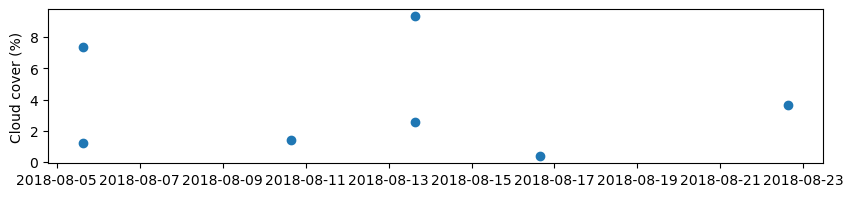

In [8]:
# Convert timestamps to datetime objects if you need to plot a time serie
gdf_items_2018["datetime"] = pd.to_datetime(gdf_items_2018.datetime)
fig, ax = plt.subplots(figsize=(10,2))
plt.scatter(gdf_items_2018.datetime, gdf_items_2018["eo:cloud_cover"])
ax.set_ylabel("Cloud cover (%)");

Here is a small view of the image depending on their cloud coverage as we want to take the one with the less cloud that could obstruate our image.

Let's display existing PNG images for 2018 

In [9]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=items_2018[1].assets["rendered_preview"].href, width=800)

The image is not complete but it is enough since our glacier is visible.

In [10]:
# Here we create IPython objects that we can use with IPywidgets
images_2018 = {it.id: IPython.display.Image(url=it.assets["rendered_preview"].href, width=500) for it in items_2018}
names = list(images_2018.keys())

In [11]:
# Interactive function to show images, parameter name must be same than in interact() arguments
def loadimg_2018(i=0):
    IPython.display.display(images_2018[names[i]])
    return names[i]

We display an interactive widget to observe the different images found and choose an interesting one

In [12]:
# The first display will be slow, before the PNG file is cached
ipywidgets.interact(loadimg_2018,  i=(0, len(images_2018)-1));

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

The August 16, 2018 image has a very low cloud cover. Therefore, we will keep it as the "before" comparison.
Its index will be 1.

In [13]:
# Put 2nd image as "before" 
before = items_2018[1]

In [14]:
# Single STAC item
before;

### Search for the "latest" image

For the "after" comparison, we will take an image of the glacier as recent as possible and preferably at the same period (August) but in 2022.

In [15]:
# Define your temporal range
daterange = {"interval": ["2022-08-01", "2022-08-31"]}

In [16]:
# Define your search with CQL2 syntax
search = catalog.search(filter_lang="cql2-json", filter={
  "op": "and",
  "args": [
    {"op": "s_intersects", "args": [{"property": "geometry"}, aoi]},
    {"op": "anyinteracts", "args": [{"property": "datetime"}, daterange]},
    {"op": "=", "args": [{"property": "collection"}, "sentinel-2-l2a"]},
    {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 10]}
  ]
})

items_2022 = search.item_collection()
print(f"We found {len(items_2022)} items for august 2022\n")

We found 3 items for august 2022



In [17]:
# Convert items metadata to GeoDataFrame
gdf_items_2022 = gpd.GeoDataFrame.from_features(items_2022.to_dict(), crs="epsg:4326")
gdf_items_2022

geometry  \
0  POLYGON ((-49.05454 70.29028, -49.22736 70.194...   
1  POLYGON ((-51.00052 69.79430, -50.86191 69.910...   
2  POLYGON ((-51.56964 69.31582, -51.52222 69.356...   

                      datetime     platform  proj:epsg instruments  \
0  2022-08-30T15:38:09.024000Z  Sentinel-2B      32622       [msi]   
1  2022-08-01T15:08:09.024000Z  Sentinel-2B      32622       [msi]   
2  2022-08-01T15:08:09.024000Z  Sentinel-2B      32622       [msi]   

  s2:mgrs_tile constellation  \
0        22WEC    Sentinel 2   
1        22WEC    Sentinel 2   
2        22WDC    Sentinel 2   

                                       s2:granule_id  eo:cloud_cover  \
0  S2B_OPER_MSI_L2A_TL_ESRI_20220831T203743_A0286...        0.092247   
1  S2B_OPER_MSI_L2A_TL_ESRI_20220802T101106_A0282...        4.676557   
2  S2B_OPER_MSI_L2A_TL_ESRI_20220802T103023_A0282...        2.491518   

                       s2:datatake_id  ... s2:cloud_shadow_percentage  \
0  GS2B_20220830T153809_028637_N04.00  ...                   0.309977   
1  GS2B_20220801T150809_028222_N04.00  ...                   0.026136   
2  GS2B_20220801T150809_028222_N04.00  ...                   0.011325   

  s2:nodata_pixel_percentage s2:unclassified_percentage  \
0                  61.655760                   0.009570   
1                   5.831716                   0.003058   
2                  90.185845                   0.012880   

  s2:dark_features_percentage s2:not_vegetated_percentage  \
0                    0.731955                   28.869820   
1                    0.081621                   10.454942   
2                    0.279547                   24.935970   

  s2:degraded_msi_data_percentage  s2:high_proba_clouds_percentage  \
0                          0.0209                         0.000078   
1                          0.0120                         0.002650   
2                          0.0000                         0.000372   

   s2:reflectance_conversion_factor  s2:medium_proba_clouds_percentage  \
0                          0.979727                           0.080834   
1                          0.969991                           3.652522   
2                          0.969991                           0.025490   

   s2:saturated_defective_pixel_percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  

[3 rows x 34 columns]

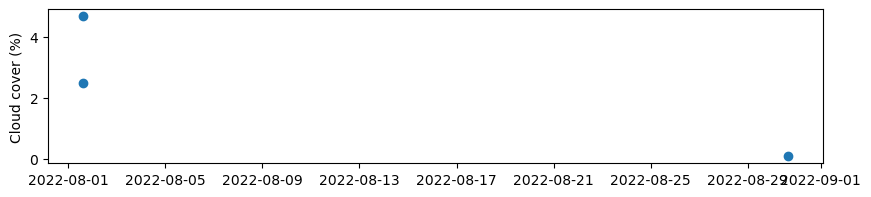

In [18]:
# Convert timestamps to datetime objects if you need to plot a time serie
gdf_items_2022["datetime"] = pd.to_datetime(gdf_items_2022.datetime)
fig, ax = plt.subplots(figsize=(10,2))
plt.scatter(gdf_items_2022.datetime, gdf_items_2022["eo:cloud_cover"])
ax.set_ylabel("Cloud cover (%)");

We had already spotted the image of August 31 on the Explorer. Let's verify it in case there is a problem. Its index is 0.

In [19]:
items_2022[0].assets["rendered_preview"].href

'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2B_MSIL2A_20220830T153809_R011_T22WEC_20220831T203742&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0'

We will keep it as the "after" comparison.

In [20]:
after = items_2022[0]

In [21]:
# Single STAC item
after;

## Explore a dataset 


In [22]:
# Rich provides an easy way to build pretty HTML tables
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in before.assets.items():
    table.add_row(asset_key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

The layers that will be of interest to us are the three RGB colors (Red, Green, Blue) and the NIR and SWIR

The rendered_preview layer allows to visualize directly the image like this :

In [23]:
# Build IPython image object from pre-rendered image url
IPython.display.Image(url=before.assets["rendered_preview"].href, width=800)

We can also observe the glacier with an interactive map.

In [24]:
# Load full georeferenced image with Leafmap
m = leafmap.Map()
m.add_stac_layer(
    collection="sentinel-2-l2a",
    name=after.datetime.strftime('%Y.%m.%d'),
    item=after.id, 
    assets=["visual"])
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Rasterio

In [25]:
# Open a remote 8bit GeoTIFF dataset to fetch image geometry
with rio.open(before.assets["visual"].href) as ds:
    profile = ds.profile

In [26]:
# We can use the same profile dict for different bands since this 3 things are constant
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint8',
    'nodata': None,
    'width': 10980,
    'height': 10980,
    'count': 3,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 7800000.0),
    'blockxsize': 512,
    'blockysize': 512,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'pixel'
}

In [27]:
# Let's keep a reference to the CRS
crs = profile['crs']

### Focus on the area

The picture is 10980 x 10980 pixels.

The middle of the zone that we are going to observe is located at 528_980 and 7_748_000

In [28]:
# Map size
size = 500

We go to the exact coordinate and + - size/2 to center on the element we want to see.

We multiply it by 10 since our resolution is of 10 meters.

In [29]:
# Behind part of the glacier coords
horizontal_coord = 528_980
vertical_coord = 7_748_000

In [30]:
# Horizontal coordinates
left_coord = horizontal_coord - (size/2) * 10
right_coord = horizontal_coord + (size/2) * 10

In [31]:
# Vertical coordinates
top_coord = vertical_coord + (size/2) * 10
bottom_coord = vertical_coord - (size/2) * 10

In [32]:
print(left_coord, bottom_coord, right_coord, top_coord)

526480.0 7745500.0 531480.0 7750500.0


In [33]:
warped_aoi_bounds = (
    left_coord,
    bottom_coord,
    right_coord,
    top_coord
)
warped_aoi_bounds

(526480.0, 7745500.0, 531480.0, 7750500.0)

In [34]:
# Define the window
aoi_window = rio.windows.from_bounds(*warped_aoi_bounds, transform=profile["transform"])

# Round pixel size and offsets
aoi_window = aoi_window.round_shape().round_offsets()
aoi_window

Window(col_off=2650, row_off=4950, width=500, height=500)

In [35]:
# Extract 8bit image within ROI, get data as numpy arrays
with rio.open(before.assets["visual"].href) as ds:
    viz_before = ds.read(window=aoi_window)

In [36]:
with rio.open(after.assets["visual"].href) as ds:
    viz_after = ds.read(window=aoi_window)

In [37]:
# Bands, Latitude, Longitude
print("bands: {},\nrows: {},\ncols: {}\n".format(*viz_before.shape) + f"dtype: {viz_before.dtype}")

bands: 3,
rows: 500,
cols: 500
dtype: uint8


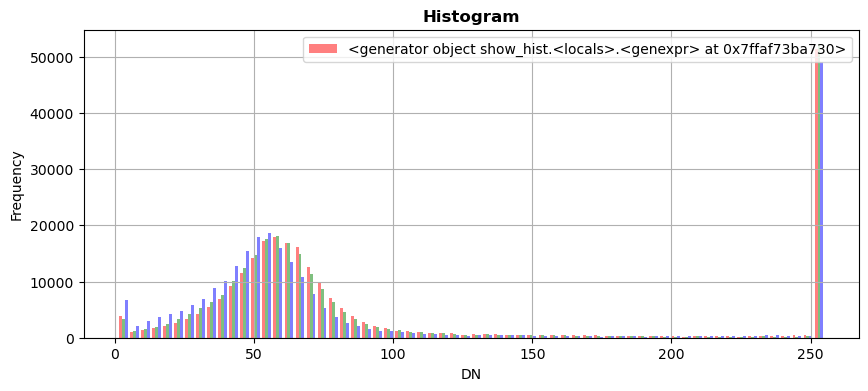

In [38]:
# Visualize histogram of pixel values.
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(viz_before, bins=64, stacked=False, alpha=0.5, title="Histogram")
# The legend is not displayed properly, most likely a rasterio matplotlib bug in our bleeding edge jupyter env

As we see, there is a huge quantity of values at 255.

It seems logical, since white color is at 255 in RGB.

## Numpy array manipulations and plotting

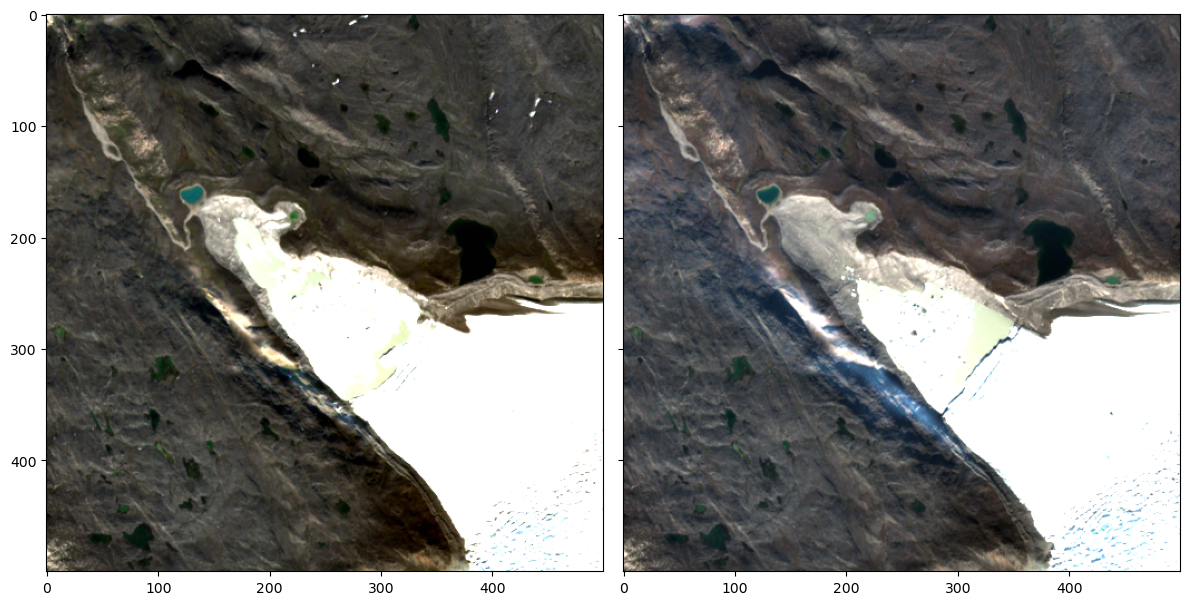

In [39]:
# Plot two images side by side, matplotlib axis with pixel coords
fig, axes = plt.subplots(1,2, figsize=(12,16), sharey=True, layout="tight")
axes[0].imshow(rio.plot.reshape_as_image(viz_before))
axes[1].imshow(rio.plot.reshape_as_image(viz_after));

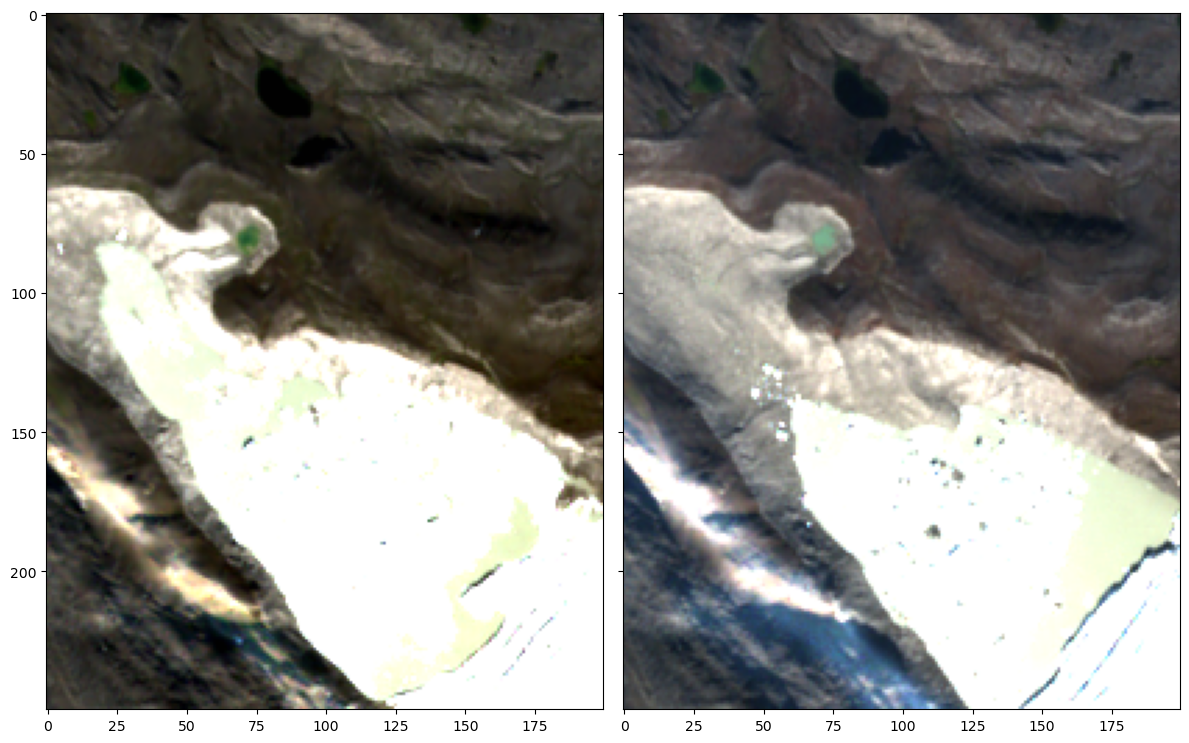

In [40]:
# Zoom on the glacier zone
fig, axes = plt.subplots(1,2, figsize=(12,16), sharey=True, layout="tight")
axes[0].imshow(np.moveaxis(viz_before, 0, 2)[100:350, 150:350, :])
axes[1].imshow(np.moveaxis(viz_after, 0, 2)[100:350, 150:350, :]);

Without even processing further, we can already observe that the glacier has lost a lot of ice.

The width of the image being 2 km, we notice that hectares of ice have disappeared

### Stacked array

In [41]:
# Load 16bit data as numpy array, using rasterio to open remote COG file
def rio_stack(
    item: pystac.Item,
    band_list: list,
    window: rio.windows.Window = None
):
    """Load and stack different bands in a STAC item, return stacked array and geometry profile"""
    array_list = []
    # Collect arrays
    for band_id in band_list:
        url = item.assets[band_id].href
        with rasterio.open(url) as ds:
            profile = ds.profile
            data = ds.read(1, window=window)  # read(1) returns 2D array
            array_list.append(data)
    # Update metadata dict
    profile["count"] = len(array_list)
    if window is not None:
        # Update image geometry
        profile["transform"] = rio.windows.transform(aoi_window, profile["transform"])
        # ! Width and height are integer since we used aoi_window.round_shape() !
        profile["width"], profile["height"] = aoi_window.width, aoi_window.height

    # N.B. this function is valid if only if all bands have the same geometry
    return np.stack(array_list), profile

We stack layers that we will need for the following steps. They are adjusted to our defined size window.

Notice that all these layers have the same resolution of 10m.  
The layers kept are Red, Green, Blue and NIR

In [42]:
# Here we also reorder BGR bands to RGB
array_before, profile = rio_stack(before, ["B04", "B03", "B02", "B08"], aoi_window)
array_after, profile = rio_stack(after, ["B04", "B03", "B02", "B08"], aoi_window)

# Make sure to check the profile dict
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': 0.0,
    'width': 500,
    'height': 500,
    'count': 4,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(10.0, 0.0, 526480.0,
       0.0, -10.0, 7750500.0),
    'blockxsize': 512,
    'blockysize': 512,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

In [43]:
array_before.max()

13496

In [44]:
array_after.max()

13000

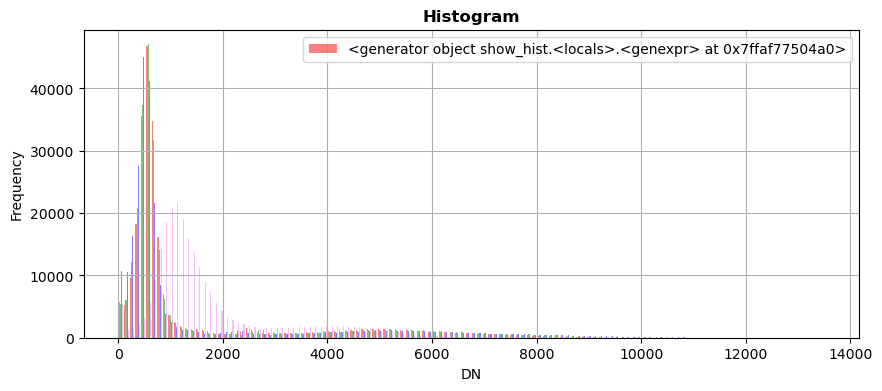

In [45]:
fig, ax = plt.subplots(figsize=(10,4))
rio.plot.show_hist(array_before, bins=128, stacked=False, alpha=0.5, title="Histogram")

In [46]:
# # Write raster data (always make sure the profile dict is correct)
# img_path = before.id + "_RGB_NIR.tif"
# # Open in "write" mode, here you may pass other params for GDAL as kwargs (after **profile)
# with rasterio.open(img_path, "w", **profile) as w:
#    w.write(array_before)

In [47]:
array_reshaped = array_before.reshape([4, -1])  # or array_before.reshape([4, 2095*1260])
print("Before array :")
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

Before array :
Min:  [1 1 1 1]
Max:  [10712 12584 13496 10648]
Mean [1558.814052 1618.70074  1570.866612 1743.627316]
Std [1963.11428705 2149.68255745 2236.18209672 1289.57173878]


There is no 0, it means there is no pixel without data

In [49]:
array_reshaped = array_after.reshape([4, -1])  # or array_before.reshape([4, 2095*1260])
print("After array :")
print("Min: ", array_reshaped.min(axis=1))
print("Max: ", array_reshaped.max(axis=1))
print("Mean", array_reshaped.mean(axis=1))
print("Std", array_reshaped.std(axis=1)) 

After array :
Min:  [ 989 1002 1020    0]
Max:  [11176 12584 13000 10872]
Mean [2449.9623   2554.295468 2595.775404 2552.166856]
Std [1653.96630296 1873.76361685 1937.86256472  979.35670668]


In this array, zero is used as nodata value.

### Let's display NaN values


Now, we will check where the NaNs values are located 

In [51]:
with rasterio.open(after.assets['B08'].href) as ds:
    profile = ds.profile
    mask = ds.read_masks(window=aoi_window)
    data = ds.read(window=aoi_window)

In [52]:
assert mask.shape == data.shape
# A rasterio mask is encoded with 8bit, 255 for invalid data, else 0
mask

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

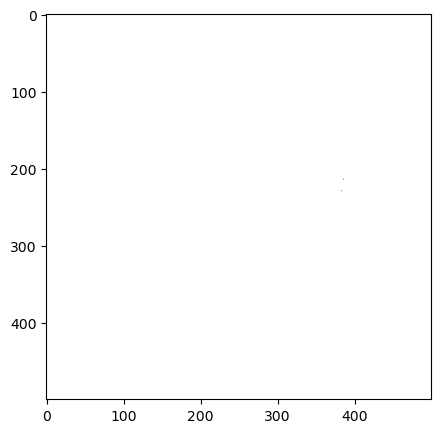

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(mask[0], cmap="gray")

We can see there are 2 little dots which represent NaN values. (x = 400, y = 200)

In [54]:
# Check if mask is empty
mask.astype(bool).all()

False

In [55]:
# Let's build a numpy masked array. We need to invert it since GDAL and Numpy aren't using the same convention
mask = ~mask.astype(bool)  # ~ operator (bitwise not) is equivalent to np.invert
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [56]:
# Build a mask, we decide to fill missing values with the dataset declared nodata value (e.g. zero)
masked_data = np.ma.masked_array(data, mask, fill_value=profile['nodata'])

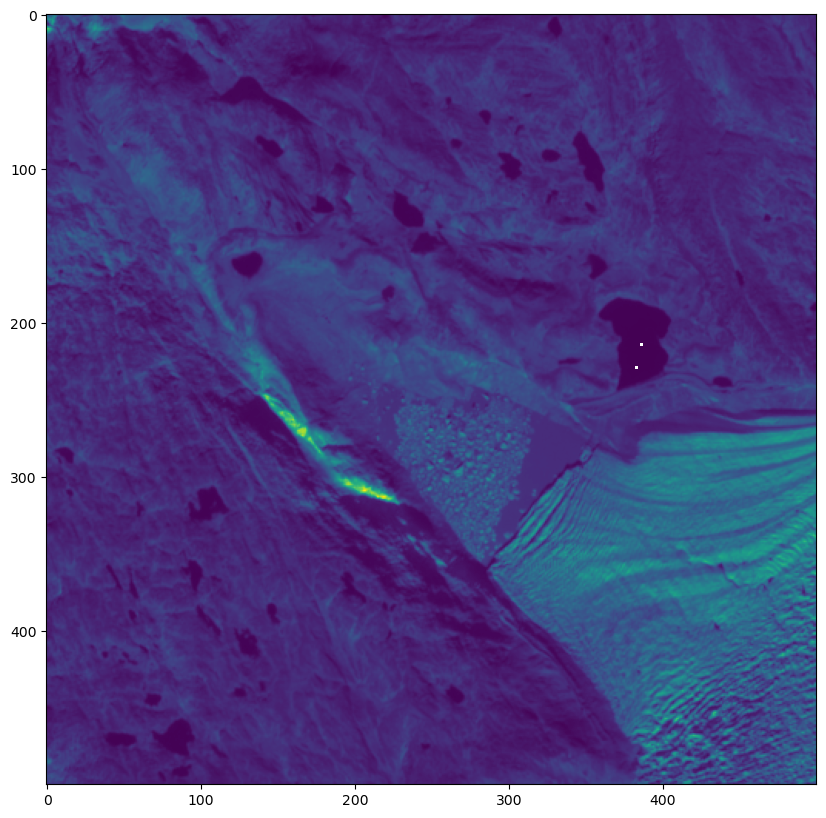

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(masked_data[0])

Zero values are not in our study area. (These are the two small white dots located in a dark area)

In principle we should remove them, but they won't bother us for the rest of the analysis.

## Image resampling

We want to use the SWIR layer which has a 20m resolution

If we are going to use the B12 with other layers, we will need to upsample the array. 

We could also use others with 20m resolution, but we want maximum precision.

In [58]:
# GSD stands for Ground Sampling Distance
before.assets['B08'].extra_fields["gsd"] == before.assets['B12'].extra_fields["gsd"]

False

In [59]:
# Resamplign algorithms : 
def rio_open_resampled(url, scale_factor=2):
    """Open a dataset using rasterio and scale pixel size according to given factor"""
    with rio.open(url) as ds:
        profile = ds.profile
        # compute new shape
        new_height, new_width = int(ds.height * scale_factor), int(ds.width * scale_factor)
        # read data and resample on the fly
        data = ds.read(
            out_shape=(ds.count, new_height, new_width),
            resampling=rio.enums.Resampling.cubic
        )  # https://en.wikipedia.org/wiki/Bicubic_interpolation
        # scale image transform
        transform = ds.transform * ds.transform.scale(
            (ds.width / data.shape[-1]),
            (ds.height / data.shape[-2])
        )
        # update metadata
        profile.update({"transform": transform, "height": new_height, "width": new_width})

        return data, profile

We increase the resolution by multiplying each pixel vertically and horizontally.

In [60]:
# Resample SWIR layer
array_swir, profile = rio_open_resampled(before.assets['B12'].href, scale_factor=2)

In [61]:
# This is a full size image, sadly we cannot use both window and out_shape when reading a dataset
rich.print(profile)

{
    'driver': 'GTiff',
    'dtype': 'uint16',
    'nodata': None,
    'width': 10980,
    'height': 10980,
    'count': 1,
    'crs': CRS.from_epsg(32622),
    'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 7800000.0),
    'blockxsize': 512,
    'blockysize': 512,
    'tiled': True,
    'compress': 'deflate',
    'interleave': 'band'
}

The array is now at the right size to match the others. We can now adjust it to our window.

In [62]:
def windowed_array(array, window):
    col_start, row_start = window.col_off, window.row_off
    col_end, row_end = window.col_off + window.width, window.row_off + window.height
    return array[:, row_start:row_end, col_start:col_end]

In [63]:
def get_s2_bands(item: pystac.Item, window: rasterio.windows.Window = None):
    array, profile = rio_stack(item, ["B04", "B03", "B02", "B08"], window)
    b12, _ = rio_open_resampled(item.assets["B12"].href)
    if window is not None:
        b12 = windowed_array(b12, window)
    array = np.concatenate([array, b12])
    profile['count'] += 1
    return array, profile

In [64]:
get_s2_bands(before, aoi_window)[0].shape

(5, 500, 500)

Now we have 5 layers :

Red, Green, Blue, NIR, SWIR

Their size is the one that has been defined earlier. 

## Compute


### Normalized Difference Snow Index (NDSI)

Here is the index that has been used :  
https://www.researchgate.net/publication/278750915_Glacier_mapping_and_monitoring_based_on_spectral_data

In [65]:
def compute_ndsi(array: np.ndarray):
    array = array.astype(np.float32)
    green, swir = array[1], array[4]
    return (green - swir) / (green + swir)

Let's compute the before & after arrays

In [66]:
# NDSI before
array_before, profile = get_s2_bands(before, window=aoi_window)
ndsi_before = compute_ndsi(array_before)

In [67]:
# NDSI after
array_after, profile = get_s2_bands(after, window=aoi_window)
ndsi_after = compute_ndsi(array_after)

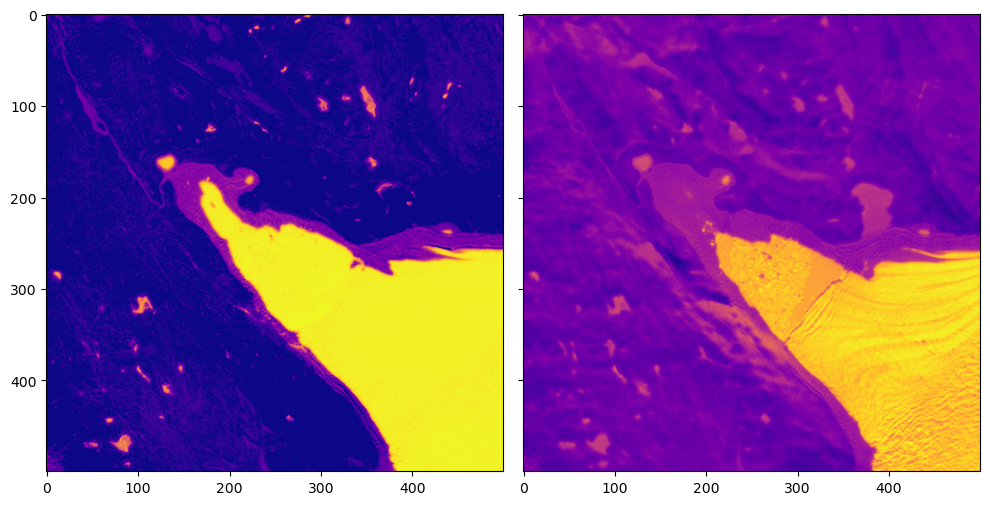

In [68]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,10), sharey=True, layout='tight')
axes[0].imshow(ndsi_before, vmin=-0.5, cmap="plasma", interpolation="bilinear")
axes[1].imshow(ndsi_after, vmin=-0.5, cmap="plasma", interpolation="bilinear");

As we saw on the other notebook for the facade, the colorimetry is absolutely not the same between 2018 and 2022.

Therefore, it is normal that the results are different but it is not very hard to determine the difference.

The more it's yellow and more it's snow

In [69]:
def get_dndsi(before: pystac.Item, after: pystac.Item, window: rasterio.windows.Window = None):
    array_before, profile = get_s2_bands(before, window=aoi_window)
    array_after, profile = get_s2_bands(after, window=aoi_window)
    nbr_before, nbr_after = compute_ndsi(array_before), compute_ndsi(array_after)
    dnbr = nbr_before - nbr_after
    profile.update({"dtype": "float32", "count": 1})
    return dnbr, profile

Get the NDSI difference between before and after

In [70]:
dndsi, profile = get_dndsi(before, after, aoi_window)

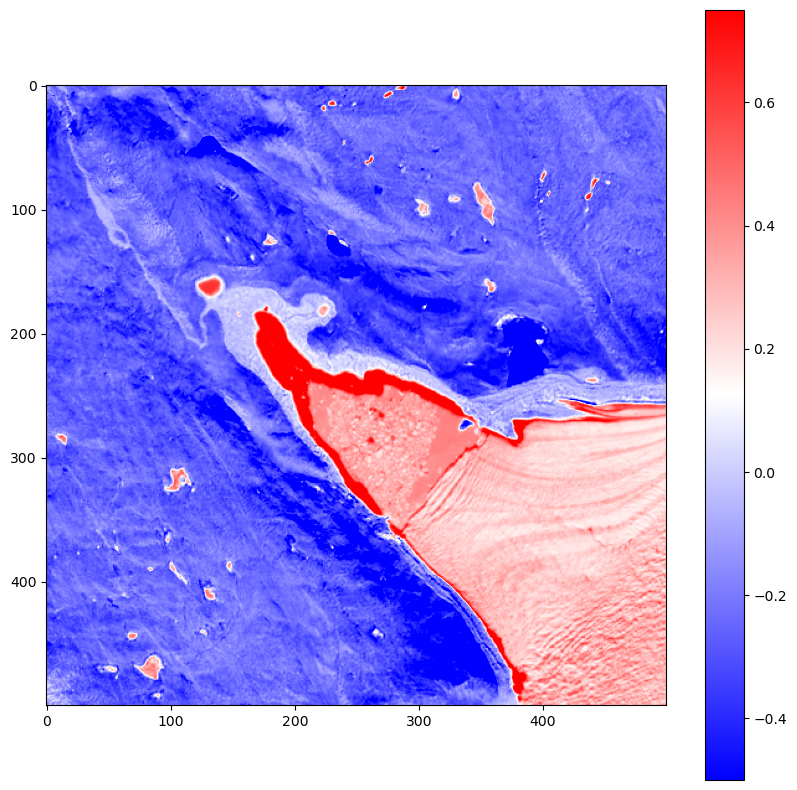

In [71]:
# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi, vmin=-0.5, vmax=0.75, cmap='bwr')
fig.colorbar(ax.get_children()[0]);  #Sometimes it is necessary to pass the mappable object to Colorbar()

The part that interests us the most (in dark red) is correctly delimited!

We can keep the values with the most coefficient like this:

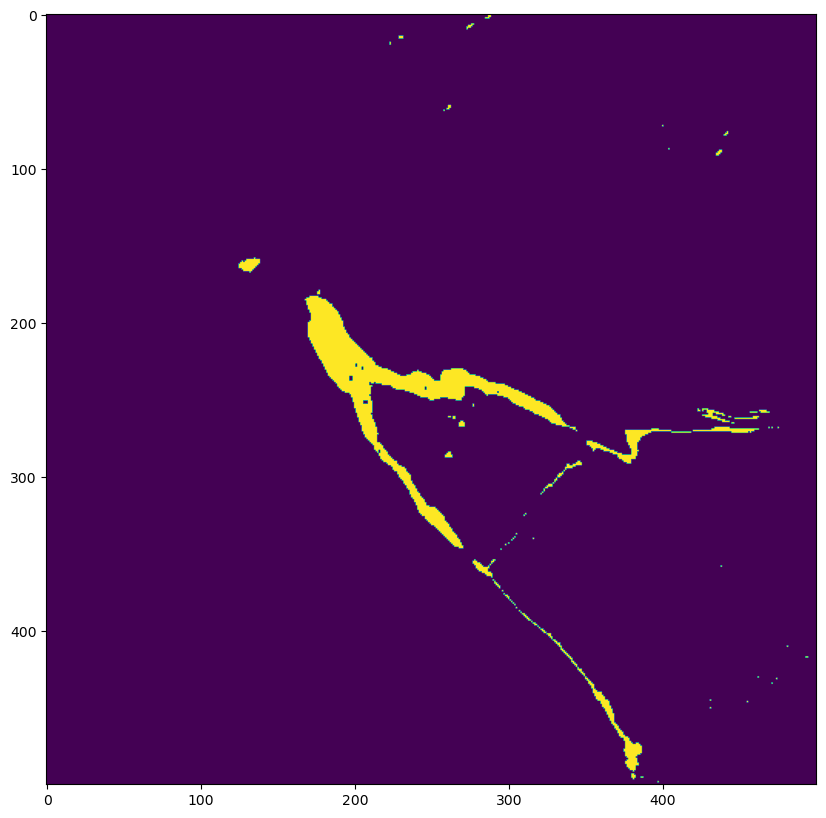

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(dndsi > 0.6)

In [73]:
profile.update({"compress": "lzw", "nodata": None})  # Use LZW compression. Unset nodata.
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 500, 'height': 500, 'count': 1, 'crs': CRS.from_epsg(32622), 'transform': Affine(10.0, 0.0, 526480.0,
       0.0, -10.0, 7750500.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [74]:
# Save 
profile.update({"dtype": "uint8", "count": 1, "nodata": None})
with rasterio.open("dNDSI.tif", "w", **profile) as w:
    w.write_band(1, np.where(dndsi > 0, dndsi * 1000, 0).astype(np.uint16))

In [75]:
# You can use np.digitize to create a reclassified array based on thresholds
thresholds = [-0.4, -0.2, -0.1, 0.1, 0.2, 0.30, 0.37, 0.66]
# Source : https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio

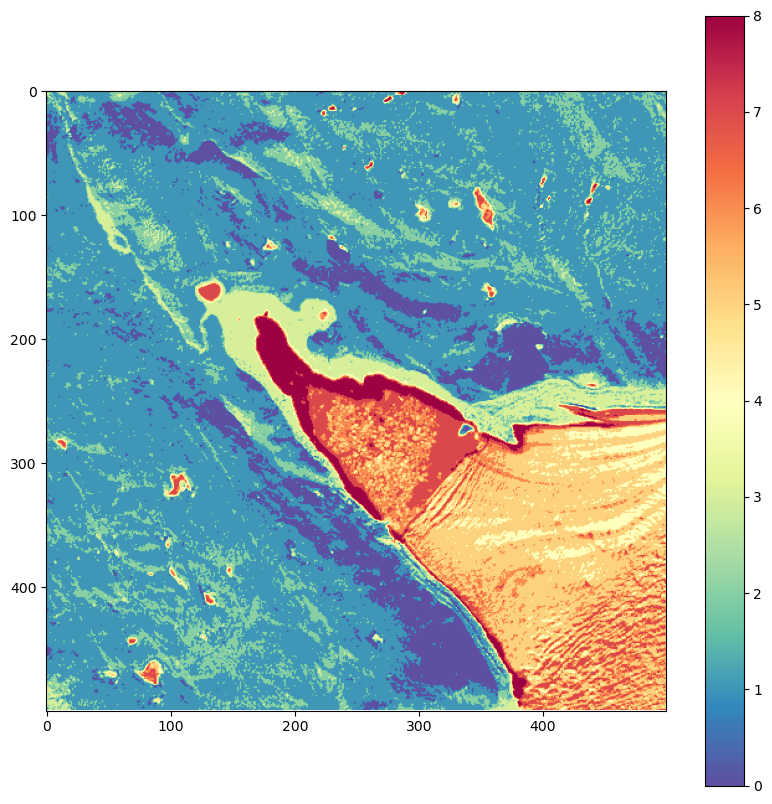

In [76]:
reclassified_dndsi = np.digitize(dndsi, thresholds).astype("uint8")
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(reclassified_dndsi, cmap='Spectral_r')
fig.colorbar(ax.get_children()[0])

The red parts are the ones we are most interested to compare the differences.

## Vectorize raster blobs

In [77]:
geoms, values = [], []
# We create a list of shapes using source image transform
for geom, value in rio.features.shapes(
    reclassified_dndsi,
    transform=profile['transform'],
    mask=(reclassified_dndsi >= 3),  # also we can mask some values
):
    geoms.append(shapely.geometry.shape(geom))
    values.append(value)

In [78]:
# Create pandas series with our data lists: polygons and pixel values
geoms = gpd.GeoSeries(geoms)
values = pd.Series(values)

In [79]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(values.rename("dNBR_class"), geometry=geoms, crs=crs)
gdf["area_ha"] = gdf.area / 10_000
print("Number of polygons :", len(gdf))

Number of polygons : 6142


In [80]:
# We have a lot of isloated pixels. It's better to remove them or leafmap will take too long to render
gdf.sort_values("area_ha").head()

dNBR_class                                           geometry  area_ha
3070         6.0  POLYGON ((529500.000 7747080.000, 529500.000 7...     0.01
3703         7.0  POLYGON ((529630.000 7746640.000, 529630.000 7...     0.01
3702         6.0  POLYGON ((529560.000 7746640.000, 529560.000 7...     0.01
2233         6.0  POLYGON ((528930.000 7747490.000, 528930.000 7...     0.01
3701         4.0  POLYGON ((529530.000 7746640.000, 529530.000 7...     0.01

In [81]:
gdf = gdf[gdf.area_ha >= 0.1]
print("Number of polygons :", len(gdf))

Number of polygons : 552


In [82]:
# Explore 
gdf.explore("dNBR_class", tiles=folium_tile, cmap="copper_r", style_kwds={"stroke": None})

We filter to keep only high coefficients.

In [83]:
gdf = gdf[gdf.dNBR_class >= 7.1]
print("Number of polygons :", len(gdf))

Number of polygons : 9


In [84]:
# Explore
gdf.explore("dNBR_class", tiles=folium_tile, cmap="copper_r", style_kwds={"stroke": None})

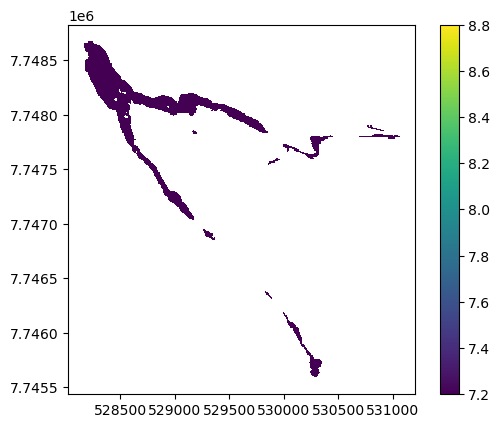

In [85]:
# Plot it (To see it on Github)
fig, ax = plt.subplots(1, 1)
gdf.plot(column='dNBR_class', ax=ax, legend=True);

In [86]:
# We drop the class to keep only the area surface
gdf.drop(['dNBR_class'], axis=1, inplace=True)

We can now add the GeoDataFrame on the map to see which part were present 4 years ago

In [87]:
m = leafmap.Map()
m.add_stac_layer(collection="sentinel-2-l2a",
                 item=after.id,
                 assets=["visual"],
                 opacity=0.6
                ),
m.add_gdf(
    gdf,
    fill_colors=["red"],
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [88]:
# surface of melted ice (in ha)
melted_area = gdf["area_ha"].sum()

In [89]:
print("The total area of ice that has melted over the observed area is", round(melted_area, 1), "ha")

The total area of ice that has melted over the observed area is 43.7 ha


In [90]:
football_pitch = 0.714 # in ha
melted_area_in_football_pitch = melted_area / football_pitch

In [91]:
print("The melted surface of ice corresponds to", round(melted_area_in_football_pitch, 1), "football pitch !")

The melted surface of ice corresponds to 61.2 football pitch !


The values are approximated but overall, we notice that a large amount of ice has melted.